### 1. Prepare the working environment

In [1]:
HOME = "../.." # path to the root of the project two levels up

# Activate the environment
using Pkg
Pkg.activate(HOME)
Pkg.precompile()

  Activating project at `c:\Users\cpaniagu\Documents\IceFloeTracker.jl`


In [2]:
using IceFloeTracker: pairfloes, deserialize, DataFrames, colorview, RGB, PaddedView, float64, mosaicview, Gray
imshow(x) = Gray.(x)

imshow (generic function with 1 method)

### 2. Set thresholds for the algorithm. Load data

In [3]:
# Set thresholds
t1 = (dt=(30, 100, 1300), dist=(200, 250, 300)) # elapsed time between images and distance between floes
t2 = (area=1200, arearatio=0.28, majaxisratio=0.10, minaxisratio=0.12, convexarearatio=0.14) # for small floes?
t3 = (area=10_000, arearatio=0.18, majaxisratio=0.1, minaxisratio=0.15, convexarearatio=0.2) # for large floes?
condition_thresholds = (t1, t2, t3)

mc_thresholds = (
    comp=(mxrot=10, sz=16, comp=0.25, mm=0.22, psi=0.95),
    goodness=(corr=0.68, area2=0.236, area3=0.18),
)
 (area3=0.18, area2=0.236, corr=0.68) # large, small, psi-s correlation
dt = [15, 20] # elapsed time between images

# Load data
data = deserialize(joinpath(HOME, "test",  "test_inputs", "tracker","tracker_test_data.dat"))
fieldnames(typeof(data))

(:imgs, :props)

### 3. Inspect `data` container

In [4]:
data.imgs

3-element Vector{BitMatrix}:
 [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
 [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
 [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]

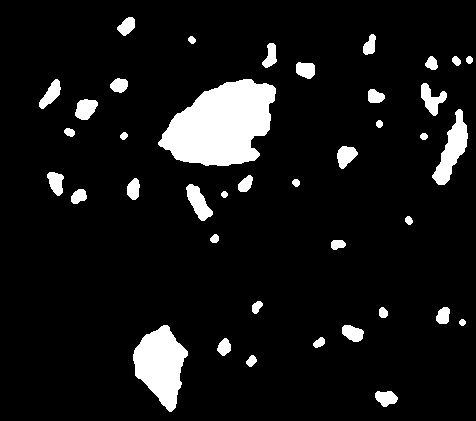

In [5]:
imshow(data.imgs[1])

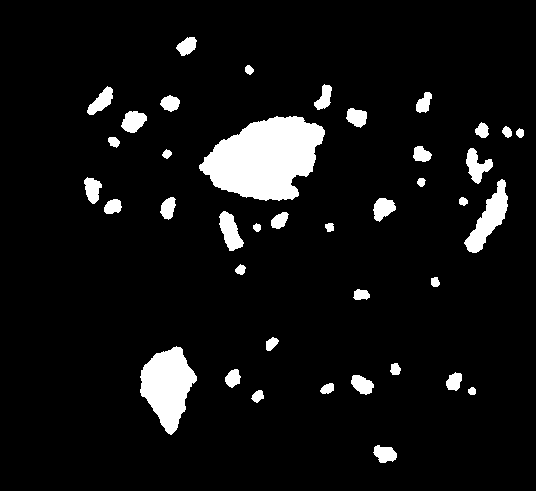

In [6]:
imshow(data.imgs[2])

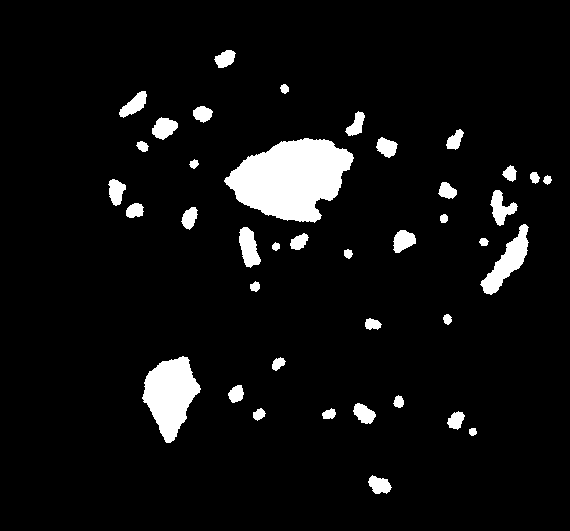

In [7]:
imshow(data.imgs[3])

In [8]:
data.props[1][1:5, :]

Row,area,min_row,min_col,max_row,max_col,row_centroid,col_centroid,convex_area,major_axis_length,minor_axis_length
,Int32,Int32,Int32,Int32,Int32,Int64,Int64,Int32,Float64,Float64
1,321,80,40,109,61,95,51,347,34.4232,12.5325
2,277,173,48,196,64,183,56,302,25.568,14.7346
3,73,129,65,137,75,133,70,75,11.5951,8.017
4,176,190,72,204,87,197,79,186,18.0342,12.7014
5,350,100,76,120,98,110,86,371,24.8313,18.3884


### 4. Pair floes using the Tracker algo

In [9]:
# sort floe data by area
for i in 1:3
    sort!(data.props[i], :area; rev=true)
end

pairs = pairfloes(data.imgs, data.props, dt, condition_thresholds, mc_thresholds);

### 5. Inspect `pairs` container

In [10]:
typeof(pairs)

Vector{MatchedPairs} (alias for Array{IceFloeTracker.MatchedPairs, 1})

In [11]:
fieldnames(typeof(pairs[1]))

(:props1, :props2, :ratios, :dist)

In [12]:
pairs[1].props1[1:3, :] # note floe mask and psi shape descriptor have been generated

Row,area,min_row,min_col,max_row,max_col,row_centroid,col_centroid,convex_area,major_axis_length,minor_axis_length,mask,psi
,Int32,Int32,Int32,Int32,Int32,Int64,Int64,Int32,Float64,Float64,BitMatrix,Array…
1,6966,80,159,166,276,125,222,7464,119.25,77.0107,Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0],"[5.17314, 4.72092, 5.16185, 5.18999, 4.69934, 4.7112, 4.71169, 4.7027, 5.19826, 5.22056 … 11.0403, 11.0002, 11.0189, 10.5197, 9.92366, 10.1952, 10.9827, 10.9949, 10.9955, 10.9956]"
2,2899,326,134,412,188,366,161,3152,79.1884,49.2248,Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0],"[5.17556, 5.49891, 5.49271, 5.18149, 4.71844, 5.16694, 5.49651, 4.69311, 5.21883, 5.49015 … 9.94183, 9.83228, 9.92116, 10.2061, 9.86869, 9.9149, 9.41547, 10.2039, 10.9903, 10.9954]"
3,1176,110,433,185,468,150,453,1442,80.179,20.6145,Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0],"[5.49732, 5.82728, 6.75379, 6.27303, 6.28253, 6.28831, 5.77932, 5.49678, 5.88162, 5.7628 … 9.40384, 10.1951, 10.2177, 9.44808, 9.42617, 9.42481, 9.42422, 9.41946, 10.2057, 10.9924]"


### 6. Visualize a tracked floe

In [13]:
f10 = pairs[1].props1[1, :] # a sample inital floe
f11 = pairs[1].props2[1, :] # floe after "day 1"
f12 = pairs[2].props2[1, :] # floe after "day 2"
floes = [f10, f11, f12]

# Get common canvas size for floes in case masks are different sizes
s = Tuple(maximum(r) for r in  eachrow(hcat([collect(size(floe.mask)) for floe in floes]...)))

(87, 130)

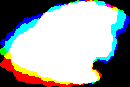

In [14]:
colorview(RGB, [PaddedView(0.0, float64.(img.mask), s) for img in [f10, f11, f12]]...)

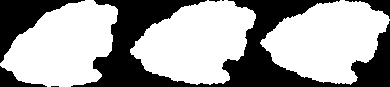

In [15]:
imshow(mosaicview([collect(PaddedView(0.0, float64.(img.mask), s)) for img in [f10, f11, f12]], nrow=1))